In [118]:
from __future__ import annotations

import logging
import os
from timeit import default_timer as timer
import pickle
import numpy as np
from scipy.linalg import expm
import scipy
import sys
sys.path.append('./utils/')
sys.path.append('../utils/')
sys.path.append('/Users/luismartinezmartinez/GitHubProjs/CSA/')
#import LayerGenDef

from LayerGenDef import AltLayer

from bqskit import Circuit
from bqskit import enable_logging
from bqskit.compiler import Compiler
from bqskit.passes import ForEachBlockPass
from bqskit.passes import QSearchSynthesisPass
from bqskit.passes import QFASTDecompositionPass
from bqskit.passes import ScanningGateRemovalPass
from bqskit.passes import ToU3Pass
from bqskit.passes import ToVariablePass
from bqskit.passes import LEAPSynthesisPass
from bqskit.passes import QSearchSynthesisPass
from bqskit.passes import UnfoldPass
from bqskit.passes import SimpleLayerGenerator
from bqskit.ir.gates import VariableUnitaryGate

from TapQub_utils import GenCliffUnit,GenQubitSym,TapperRotHam


from bqskit import MachineModel
from bqskit.ir.gates import CZGate, RZGate, SXGate

In [119]:
from bqskit.ir.gates.composed import ControlledGate 

In [120]:
import scipy.io as spio

enable_logging()


def loadMat(mol,path):
    fname=path+f'generators_noesy_{mol}.mat'

    return spio.loadmat(fname, squeeze_me=True)

def EmbedInU(TarMat):

    Dim = TarMat.shape[0]

    UR = scipy.linalg.sqrtm(np.eye(Dim)-np.dot(TarMat,TarMat.conjugate().T))
    LL = scipy.linalg.sqrtm(np.eye(Dim)-np.dot(TarMat.conjugate().T,TarMat))
    
    U_meth = np.zeros([2*Dim,2*Dim],dtype=complex)
    U_meth[0:Dim,0:Dim] = TarMat
    U_meth[0:Dim,Dim:2*Dim]=UR
    U_meth[Dim:2*Dim,0:Dim]=LL
    U_meth[Dim:2*Dim,Dim:2*Dim]=-TarMat.conjugate().T

    return U_meth

def Umetric(TarMat):
    dim = TarMat.shape[0]
    
    return np.linalg.norm(np.dot(TarMat.conj().T,TarMat)-np.eye(dim))


def run_simp_layer_flow_example(in_circuit,
        amount_of_workers: int = 10, synt_pass = QSearchSynthesisPass
) -> tuple[Circuit, float]:
    
    num_multistarts = 32
   
    instantiate_options = {
        'method': 'qfactor',
        'multistarts': num_multistarts,
    }

    # Prepare the compilation passes
    #SimpleLayerGenerator(two_qudit_gate=CNOTGate, single_qudit_gate_1=U3Gate, single_qudit_gate_2=None, initial_layer_gate=None)

    passes = [

        # Split the circuit into partitions
       #QSearchSynthesisPass(instantiate_options=instantiate_options),
       synt_pass(layer_generator=SimpleLayerGenerator(two_qudit_gate=VariableUnitaryGate(2),single_qudit_gate_1=VariableUnitaryGate(1)),
                 success_threshold=1e-3,max_layer=5000,instantiate_options=instantiate_options)
       
       #QSearchSynthesisPass(layer_generator=LayerGenDef.AltLayer(),instantiate_options=instantiate_options)

    ]
    # Create the compilation task

    with Compiler(
        num_workers=amount_of_workers,
        runtime_log_level=logging.INFO,
    ) as compiler:

        print('Starting flow using QFactor instantiation')
        start = timer()
        out_circuit = compiler.compile(in_circuit, passes)
        end = timer()
        run_time = end - start

    return out_circuit, run_time

def run_custom_layer_flow_example(in_circuit,
        amount_of_workers: int = 10, synt_pass = QSearchSynthesisPass
) -> tuple[Circuit, float]:
    
    num_multistarts = 32
   
    instantiate_options = {
        'method': 'qfactor',
        'multistarts': num_multistarts,
    }

    # Prepare the compilation passes
    #SimpleLayerGenerator(two_qudit_gate=CNOTGate, single_qudit_gate_1=U3Gate, single_qudit_gate_2=None, initial_layer_gate=None)

    passes = [

        # Split the circuit into partitions
       #QSearchSynthesisPass(instantiate_options=instantiate_options),
       synt_pass(layer_generator=AltLayer(),
                 success_threshold=1e-3,max_layer=5000,instantiate_options=instantiate_options)
       
       #QSearchSynthesisPass(layer_generator=LayerGenDef.AltLayer(),instantiate_options=instantiate_options)

    ]

    # Create the compilation task

    with Compiler(
        num_workers=amount_of_workers,
        runtime_log_level=logging.INFO,
    ) as compiler:

        print('Starting flow using QFactor instantiation')
        start = timer()
        out_circuit = compiler.compile(in_circuit, passes)
        end = timer()
        run_time = end - start

    return out_circuit, run_time

def run_qfast_flow(in_circuit,
        amount_of_workers: int = 10,threshold = 1e-3
) -> tuple[Circuit, float]:
    
    num_multistarts = 32
   
    instantiate_options = {
        'method': 'minimization'
        #'multistarts': num_multistarts,
    }

    # Prepare the compilation passes
    #SimpleLayerGenerator(two_qudit_gate=CNOTGate, single_qudit_gate_1=U3Gate, single_qudit_gate_2=None, initial_layer_gate=None)

    passes = [

        # Split the circuit into partitions
       #QSearchSynthesisPass(instantiate_options=instantiate_options),
       #QFASTDecompositionPass(gate=VariableUnitaryGate(2),success_threshold=1e-3,instantiate_options=instantiate_options)
        QFASTDecompositionPass(success_threshold=threshold,instantiate_options=instantiate_options)
       
       #QSearchSynthesisPass(layer_generator=LayerGenDef.AltLayer(),instantiate_options=instantiate_options)

    ]
    # Create the compilation task

    with Compiler(
        num_workers=amount_of_workers,
        runtime_log_level=logging.INFO,
    ) as compiler:

        print('Starting flow using QFactor instantiation')
        start = timer()
        out_circuit = compiler.compile(in_circuit, passes)
        end = timer()
        run_time = end - start

    return out_circuit, run_time


def CompressMat(Mat,cutoff):
    A = np.copy(Mat)

    U,S,V = np.linalg.svd(A)

    Dim = S.shape[0]

    for i in range(Dim):
        if S[i] <= cutoff:
            S[i]=0

    return U@np.diag(S)@V



In [4]:
AuxMats = spio.loadmat('../data/DFG_NOESYmatrices.mat',squeeze_me=True)

In [5]:
rho0 = np.array(AuxMats['rho0'].toarray())


In [6]:
rho0.flatten()

array([0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ])

In [38]:
#AuxMats['Lx'].toarray()

In [7]:
synt_pass = 'qfast' 
nworkers = 4
t_idx = 256

In [8]:
loadMat = spio.loadmat('../data/DFG.mat',squeeze_me=True)

In [9]:
len(loadMat['p']['time_grid1'].item())/2

256.0

In [10]:
#loadMat['p']['time_grid1'].item()-loadMat['p']['time_grid2'].item()

In [11]:
Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()
t_grid = loadMat['p']['time_grid1'].item()

TimeGen = (-1j*Ham+R)*t_grid[t_idx]
ExpGen = expm(TimeGen)

####Embedding in unitary...

EmbUn = EmbedInU(ExpGen)

#nqubs = 4
#SubU = np.copy(EmbUn[0:2**nqubs,0:2**nqubs])

#SubEmbU = EmbedInU(SubU)


#in_circuit = Circuit.from_unitary(SubEmbU)
in_circuit = Circuit.from_unitary(EmbUn)

In [53]:
U,D,Vdag = np.linalg.svd(ExpGen)
D= np.diag(D)

In [65]:
dimD = D.shape[0]
RightUn = np.zeros([2*D.shape[0],2*D.shape[1]],dtype=complex)

RightUn[0:dimD,0:dimD] = Vdag
RightUn[dimD:2*dimD,0:dimD] = -Vdag
RightUn[0:dimD,dimD:2*dimD] = U.conj().T
RightUn[dimD:2*dimD,dimD:2*dimD] = U.conj().T

RightUn = (1/np.sqrt(2))*RightUn

#Matrix built out from singular values of propagator
F_D = scipy.linalg.sqrtm(np.eye(16)-D@D)

F_D = np.real(F_D)

SV_mat = np.zeros([32,32],dtype=complex)

SV_mat[0:16,0:16] = D
SV_mat[16:32,16:32] = -D
SV_mat[0:16,16:32] = F_D
SV_mat[16:32,0:16] = F_D



In [66]:
Umetric(SV_mat)

2.771024778738677e-11

In [67]:
Umetric(SV_mat)

2.771024778738677e-11

In [70]:
Umetric(D@Vdag-F_D@Vdag)

2.072383115361415

# Leveraging tappering

In [97]:
#The best idea we have is to find the basis to bring the Hamiltonian into taperable form...
#However, the issue will be to synthesize the circuit for the Clifford that transforms the Hamiltonian into taperable
#form. Intuitively, clifford unitaries should be easy to synthesize into circuits...
from openfermion import QubitOperator
import re
import openfermion as of
import pennylane as qml
from scipy.cluster.hierarchy import fcluster, linkage
import cmath
from bqskit import compile


def gram_schmidt(vectors):
    """Orthogonalize a set of vectors using the Gram-Schmidt process."""
    orthogonalized_vectors = []
    for v in vectors:
        for u in orthogonalized_vectors:
            v -= np.dot(u.conj(), v) * u
        v /= np.linalg.norm(v)
        orthogonalized_vectors.append(v)
    return np.array(orthogonalized_vectors)

def cluster_eigenvalues(eigenvalues, tolerance):
    """Cluster eigenvalues that are within a certain tolerance."""
    Z = linkage(eigenvalues[:, None], method='single')
    clusters = fcluster(Z, tolerance, criterion='distance')
    return clusters


def OrthEigs(Matrix):
    """
    We obtain the eigenvalues and ensure that the eigenvectors are mutually orthogonal, something that is not always the case
    when dealing with degeneracies
    """

    # Step 1: Define a matrix
    A = np.copy(Matrix)
    
    # Step 2: Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Step 3: Cluster eigenvalues based on the tolerance
    tolerance = 1e-7
    clusters = cluster_eigenvalues(np.real(eigenvalues)+np.imag(eigenvalues), tolerance)
    
    # Step 4: Orthogonalize the degenerate eigenspaces
    orthogonalized_eigenvectors = eigenvectors.copy()
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        indices = np.where(clusters == cluster)[0]
        if len(indices) > 1:
            degenerate_vectors = eigenvectors[:, indices]
            orthogonalized_vectors = gram_schmidt(degenerate_vectors.T).T
            orthogonalized_eigenvectors[:, indices] = orthogonalized_vectors
    return eigenvalues, orthogonalized_eigenvectors

def pauli_word_to_string(pauli_word):
    terms = []
    for qubit, op in pauli_word.items():
        terms.append(f"{op}{qubit}")
    return ' '.join(terms)

def transform_pauli_string(pauli_string):
    # Regular expression to match the pattern X(0)@Z(1)@Y(2)
    pattern = re.compile(r'([XYZ])\((\d+)\)')
    
    # Find all matches and transform them to the desired format
    transformed_string = pattern.sub(lambda match: f"{match.group(1)}{match.group(2)}", pauli_string)
    
    # Replace @ with space
    transformed_string = transformed_string.replace('@', ' ')
    
    return transformed_string

    
def from_paulsen_to_of(PaulSen):
    """
    Transforms a PennyLane's Pauli sentence object to openfermion qubit operator
    """
    Qubs = QubitOperator()
    for term, coeff in PaulSen.items():
        
        str_term = pauli_word_to_string(term)
        
        #print(str_term)
        trans_str = transform_pauli_string(str_term)
        #print(trans_str)
        
        Qubs+=QubitOperator(term=trans_str,coefficient=coeff)
        #print("term is:",term)
        #print("coeff is:",coeff)   

    return Qubs

def GroupTarQub(QubOp,term_to_find):
    """
    Returns: the group of terms contained in QubOp that contain the single qubit operator term_to_find
    """
    
    grouped_terms = QubitOperator()
    for term, coefficient in QubOp.terms.items():
        #print(term)
        for op in term:
            if QubitOperator(op) == term_to_find: 
                grouped_terms+=coefficient*QubitOperator(term)
    return grouped_terms


####Utils for handling controlled versions fo circuits...
def update_loc(location,insert_loc: int):
    curr_loc = [q for q in location]
    mod_loc = [num + 1 if num >= insert_loc else num for num in curr_loc]
    return list([insert_loc])+mod_loc #The insert location must be first in the list, as it will be a control location

  
def control_circ(Inp_circ: Circuit,target_loc=0,ctrl_levels =[0],num_control_qubits: int = 1):
    """
    Define a single-qubit controlled (TODO: generalization to more than one) version of the circuit Inp_circ ,
    where the controlled qubit is located at target_loc
    """
    num_original_qubits = Inp_circ.num_qudits
    controlled_circuit = Circuit(num_control_qubits + num_original_qubits)
    #print(controlled_circuit)
    
    for op in Inp_circ:
        gate = op.gate
        location = op.location
        #print(gate)

        controlled_gate = ControlledGate(gate, num_control_qubits,control_levels=ctrl_levels)
        controlled_location = update_loc(location,target_loc)
        if gate.is_parameterized():
            params = op.params
            #print(f"Gate: {gate} with parameters {params}")
            #print("Params are:", params)
            #print(controlled_location)
            controlled_circuit.append_gate(controlled_gate, controlled_location,params)
            
        else:
            #print(controlled_location)
            controlled_circuit.append_gate(controlled_gate, controlled_location)
    
    return controlled_circuit

def FindQubHam(Untry):
    """
    Generate the qubit Hamiltonian that generates the unitary Untry
    """
    Eigs, EigVecs = OrthEigs(Untry)

    Dim = Untry.shape[0]//2
    
    phases= [cmath.phase(c) for c in Eigs]
    Mat_phases = np.zeros([2*Dim,2*Dim],dtype=complex)
    
    for i in range(2*Dim):
        Mat_phases[i,i] = 1j*phases[i] 
    
    RecMat = np.dot(EigVecs,np.dot(Mat_phases,EigVecs.conj().T))
    
    GenEvol = -1j*RecMat
    
    PauliHam = qml.pauli_decompose(GenEvol,pauli=True)
    
    QubHam = from_paulsen_to_of(PauliHam)

    return QubHam

def get_qubit_index(qubit_operator):
    terms = list(qubit_operator.terms.keys())
    if len(terms) != 1:
        raise ValueError("The operator is not a single-qubit operator.")
    term = terms[0]
    if len(term) != 1:
        raise ValueError("The operator is not a single-qubit operator.")
    qubit_index = term[0][0]
    return qubit_index

def CliffRotSynthesis(Untry,passes,gate_set={CZGate(), RZGate(), SXGate()}):
    """
    Return: circuit using generalized single and two-qbiut gates in BQSkit format. Can be transpiled to other gate sets
    TODO: In progress
    An approximate synthesis of target unitary Untry, with a workflow defined by passes, and the gate set gate_set
    """

    #First find the generator of unitary as a linear combination of Pauli products:
    QubHam = FindQubHam(Untry)
    nqubs = of.count_qubits(QubHam)

    #Then find the symmetries and clifford rotation that renders the QubHam in taperable form...
    syms = GenQubitSym(QubHam)

    print("Number of terms in the found Qubit Hamiltonian: ",len(QubHam.terms))

    if len(syms)==0:
        print("Couldnt find Z2 symmetries, aborting")
        exit()
        
    ClifffUn = GenCliffUnit(QubHam)
    RotHam = ClifffUn*QubHam*ClifffUn

    test = ClifffUn*syms[0][0]*ClifffUn # we only use one qubit symmetry for now, if any


    for key in test.terms.keys():
        tap_sym = QubitOperator(key)

    #print("Tapering symmetry is:", tap_sym)
    qub_id = get_qubit_index(tap_sym)
    rot_gen = QubitOperator('Y'+str(qub_id))
    rot_gate = (1.0/np.sqrt(2))*(1-1j*rot_gen)
    
    ZRotHam = of.hermitian_conjugated(rot_gate)*RotHam*rot_gate
    #Application of swapping gate if tappering symmetry is not X0:
    qub_id = get_qubit_index(tap_sym)
    if tap_sym != QubitOperator('X0'):
        print("Using a swapping gate")
        Swap = 0.5*(1.0+QubitOperator('Z0')*QubitOperator('Z'+str(qub_id))+QubitOperator('X0')*QubitOperator('X'+str(qub_id))
                    +QubitOperator('Y0')*QubitOperator('Y'+str(qub_id)))
    else:
        Swap = 1.0

    ZRotHam = Swap*ZRotHam*Swap
    
    #We now rotate the X taperable qubit to Z:
    m = nqubs-1
    
    spRotHam = of.get_sparse_operator(ZRotHam)

    
    Subs1 = spRotHam.toarray()[0:2**m,0:2**m]
    Subs2 = spRotHam.toarray()[2**m:2**nqubs,2**m:2**nqubs]


    SubUn1 = expm(-1j*Subs1)
    SubUn2 = expm(-1j*Subs2)
    
    ###Compilation of the the unitaries separately...
    Sub1Circ = Circuit.from_unitary(SubUn1)
    out_circ1, run_time = run_qfast_flow(Sub1Circ,6)

    print("Compilation of first circuit took:",run_time)

    Sub2Circ = Circuit.from_unitary(SubUn2)
    out_circ2, run_time = run_qfast_flow(Sub2Circ,6)
    
    print("Compilation of second circuit took:",run_time)

    ctrl_Sub1Circ = control_circ(Sub1Circ,ctrl_levels=[0])

    ctrl_Sub2Circ = control_circ(Sub2Circ,ctrl_levels=[1])
    
    ###Finally, compiling the gates that bring matrix into block-diagonal format...
    sp_rot_gate = of.get_sparse_operator(rot_gate,n_qubits=nqubs)
    sp_swap = of.get_sparse_operator(Swap,n_qubits=nqubs)
    sp_Cliff = of.get_sparse_operator(ClifffUn,n_qubits=nqubs)
    
    
    c_rot_gate = Circuit.from_unitary(sp_rot_gate.toarray())
    c_swap = Circuit.from_unitary(sp_swap.toarray())
    c_CliffUn = Circuit.from_unitary(sp_Cliff.toarray())

    circ_rot_gate, run_time = run_qfast_flow(c_rot_gate,6)
    print("Compilation of single_rot gate took:",run_time)
    
    circ_swap, runtime = run_qfast_flow(c_swap,6)
    print("Compilation of swap gate took:",run_time)

    circ_Cliff,runtime = run_custom_layer_flow_example(c_CliffUn)

    
    Tot_circ = Circuit(5)
    Tot_circ.extend(circ_Cliff)
    Tot_circ.extend(circ_rot_gate.get_inverse())
    Tot_circ.extend(circ_swap)
    Tot_circ.extend(ctrl_Sub1Circ)
    Tot_circ.extend(ctrl_Sub2Circ)
    Tot_circ.extend(circ_swap)
    Tot_circ.extend(circ_rot_gate)
    Tot_circ.extend(circ_Cliff)
    
    #Compilation using a given gate set:
    #ctrl_circ = control_circ(inst_circuit,2)

    
    """
    model = MachineModel(out_circ1.num_qudits, gate_set=gate_set)
    transCirc1 = compile(out_circ1,model=model)
    transCirc2 = compile(out_circ2,model=model)

    ctrl_trans_circ1 = control_circ(transCirc1,0,ctrl_levels=[0])
    ctrl_trans_circ2 = control_circ(transCirc2,0,ctrl_levels=[1])
    
    
    #inst_ctrl_circ = compile(ctrl_circ, model=model
    
    
    #spRedGp = of.get_sparse_operator(RedGroupHam)
    #RedUnit = expm(-1j*spRedGp.toarray())
    
    #in_circuit = Circuit.from_unitary(RedUnit)
    #out_circ, run_time = run_qfast_flow(in_circuit,6)

    #return RotHam,ClifffUn,tap_sym
    """
    #return (SubUn1,out_circ1),(SubUn2,out_circ2) 
    return Tot_circ 

    





In [98]:
from matplotlib import pyplot as plt

In [99]:
Circ = CliffRotSynthesis(EmbUn,0)

Number of terms in the found Qubit Hamiltonian:  508
Using a swapping gate


Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Node has spawned 6 workers.


Starting flow using QFactor instantiation


Connected to client.
AttachedServer running...
New CompilationTask: afb4a441-24ff-4e58-b62d-37b1d265413f.


12:53:08.815 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 1 at 0.9011044900648243 cost.


INFO - Instantiated depth 1 at 0.9011044900648243 cost.


12:53:08.815 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:53:08.815 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (1, 3).


INFO - Expanding by adding a gate on qubits (1, 3).


12:53:08.870 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 0.00682023712750246 cost.


INFO - Instantiated depth 2 at 0.00682023712750246 cost.


12:53:08.870 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:53:08.870 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (1, 2).


INFO - Expanding by adding a gate on qubits (1, 2).


12:53:09.379 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.005652620870304159 cost.


INFO - Instantiated depth 3 at 0.005652620870304159 cost.


12:53:09.379 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.
Finished: afb4a441-24ff-4e58-b62d-37b1d265413f.
Responding to request for task afb4a441-24ff-4e58-b62d-37b1d265413f.


12:53:09.590 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.006147111071112432 cost.


INFO - Instantiated depth 3 at 0.006147111071112432 cost.


12:53:09.590 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:09.688 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.8929755879684317 cost.


INFO - Instantiated depth 3 at 0.8929755879684317 cost.


12:53:09.688 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:09.805 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.006109547263034698 cost.


INFO - Instantiated depth 3 at 0.006109547263034698 cost.


12:53:09.806 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:10.059 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.0061470029915610125 cost.


INFO - Instantiated depth 3 at 0.0061470029915610125 cost.


12:53:10.059 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:53:10.059 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:53:10.059 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:53:10.689 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.2348741335514435 cost.


INFO - Instantiated depth 4 at 0.2348741335514435 cost.


12:53:10.689 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:11.489 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.7474158712716293 cost.


INFO - Instantiated depth 4 at 0.7474158712716293 cost.


12:53:11.489 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:12.215 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.005652918366434778 cost.


INFO - Instantiated depth 4 at 0.005652918366434778 cost.


12:53:12.216 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:12.607 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.9415254393808103 cost.


INFO - Instantiated depth 4 at 0.9415254393808103 cost.


12:53:12.607 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:13.304 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.00565232077855593 cost.


INFO - Instantiated depth 4 at 0.00565232077855593 cost.


12:53:13.304 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:53:13.304 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:53:13.304 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (1, 3).


INFO - Expanding by adding a gate on qubits (1, 3).


12:53:16.427 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.7522655951061192 cost.


INFO - Instantiated depth 5 at 0.7522655951061192 cost.


12:53:16.427 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:18.827 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.00440193784545273 cost.


INFO - Instantiated depth 5 at 0.00440193784545273 cost.


12:53:18.827 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:21.435 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.004405427443885168 cost.


INFO - Instantiated depth 5 at 0.004405427443885168 cost.


12:53:21.435 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:23.046 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.2348579715329363 cost.


INFO - Instantiated depth 5 at 0.2348579715329363 cost.


12:53:23.046 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:24.570 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.6096176217433927 cost.


INFO - Instantiated depth 5 at 0.6096176217433927 cost.


12:53:24.570 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:53:24.570 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:53:24.570 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:53:28.058 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.9228399442481299 cost.


INFO - Instantiated depth 6 at 0.9228399442481299 cost.


12:53:28.058 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:29.977 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.23479592533845017 cost.


INFO - Instantiated depth 6 at 0.23479592533845017 cost.


12:53:29.977 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:31.741 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.9993419242674605 cost.


INFO - Instantiated depth 6 at 0.9993419242674605 cost.


12:53:31.741 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:34.615 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.2735174793901889 cost.


INFO - Instantiated depth 6 at 0.2735174793901889 cost.


12:53:34.615 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:38.867 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.916865309990152 cost.


INFO - Instantiated depth 6 at 0.916865309990152 cost.


12:53:38.867 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:53:38.867 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:53:38.867 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (2, 3).


INFO - Expanding by adding a gate on qubits (2, 3).


12:53:41.909 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 7 at 0.25795208325391983 cost.


INFO - Instantiated depth 7 at 0.25795208325391983 cost.


12:53:41.909 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:45.136 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 7 at 0.0043891160100222315 cost.


INFO - Instantiated depth 7 at 0.0043891160100222315 cost.


12:53:45.136 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:53:45.136 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 2).


INFO - Expanding by adding a gate on qubits (0, 2).


12:53:49.170 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.8413186518522076 cost.


INFO - Instantiated depth 8 at 0.8413186518522076 cost.


12:53:49.170 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:53:55.045 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.0043014877414665476 cost.


INFO - Instantiated depth 8 at 0.0043014877414665476 cost.


12:53:55.045 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:03.107 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.0003596104852905402 cost.


INFO - Instantiated depth 8 at 0.0003596104852905402 cost.


12:54:03.107 - INFO     | bqskit.passes.synthesis.qfast: Final gate added at location (0, 1).


INFO - Final gate added at location (0, 1).


12:54:16.942 - INFO     | bqskit.passes.synthesis.qfast: Final circuit found with cost: 0.000939991138437346.


INFO - Final circuit found with cost: 0.000939991138437346.


12:54:16.942 - INFO     | bqskit.passes.synthesis.qfast: Successful synthesis.


INFO - Successful synthesis.
Shutting down node.
Shutting down node.
Shutting down node.


Compilation of first circuit took: 68.26900773396483


Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Node has spawned 6 workers.


Starting flow using QFactor instantiation


Connected to client.
AttachedServer running...
New CompilationTask: 7894c125-5340-46c2-949a-de584c499fa0.


12:54:19.415 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 1 at 0.050958587434508096 cost.


INFO - Instantiated depth 1 at 0.050958587434508096 cost.


12:54:19.415 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:54:19.415 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:54:19.488 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 0.050959357844816644 cost.


INFO - Instantiated depth 2 at 0.050959357844816644 cost.


12:54:19.488 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:19.594 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 0.9997548064535822 cost.


INFO - Instantiated depth 2 at 0.9997548064535822 cost.


12:54:19.594 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:19.683 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 0.05095856355125694 cost.


INFO - Instantiated depth 2 at 0.05095856355125694 cost.


12:54:19.683 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:19.786 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 0.11340039806110147 cost.


INFO - Instantiated depth 2 at 0.11340039806110147 cost.


12:54:19.786 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:19.886 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 0.9991375483062348 cost.


INFO - Instantiated depth 2 at 0.9991375483062348 cost.


12:54:19.887 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:54:19.887 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:54:19.887 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (2, 3).


INFO - Expanding by adding a gate on qubits (2, 3).


12:54:19.990 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.05095856174518587 cost.


Finished: 7894c125-5340-46c2-949a-de584c499fa0.
Responding to request for task 7894c125-5340-46c2-949a-de584c499fa0.
INFO - Instantiated depth 3 at 0.05095856174518587 cost.


12:54:19.990 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:20.128 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.050957571689965064 cost.


INFO - Instantiated depth 3 at 0.050957571689965064 cost.


12:54:20.128 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:20.273 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.9801671962054739 cost.


INFO - Instantiated depth 3 at 0.9801671962054739 cost.


12:54:20.273 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:20.483 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.05095877530717874 cost.


INFO - Instantiated depth 3 at 0.05095877530717874 cost.


12:54:20.483 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:20.695 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 3 at 0.9995951881314042 cost.


INFO - Instantiated depth 3 at 0.9995951881314042 cost.


12:54:20.695 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:54:20.695 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:54:20.695 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 2).


INFO - Expanding by adding a gate on qubits (0, 2).


12:54:21.167 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.05095766077924868 cost.


INFO - Instantiated depth 4 at 0.05095766077924868 cost.


12:54:21.167 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:21.274 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.48308266139806244 cost.


INFO - Instantiated depth 4 at 0.48308266139806244 cost.


12:54:21.274 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:21.515 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 4 at 0.03711599033223478 cost.


INFO - Instantiated depth 4 at 0.03711599033223478 cost.


12:54:21.515 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:54:21.515 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:54:21.918 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.03681040811568881 cost.


INFO - Instantiated depth 5 at 0.03681040811568881 cost.


12:54:21.918 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:22.286 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 5 at 0.029067858243656985 cost.


INFO - Instantiated depth 5 at 0.029067858243656985 cost.


12:54:22.286 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:54:22.286 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (2, 3).


INFO - Expanding by adding a gate on qubits (2, 3).


12:54:22.816 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.03683785924628413 cost.


INFO - Instantiated depth 6 at 0.03683785924628413 cost.


12:54:22.816 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:24.135 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.6818031579263115 cost.


INFO - Instantiated depth 6 at 0.6818031579263115 cost.


12:54:24.135 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:26.687 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.8148315646664251 cost.


INFO - Instantiated depth 6 at 0.8148315646664251 cost.


12:54:26.687 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:26.996 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.9465645901444673 cost.


INFO - Instantiated depth 6 at 0.9465645901444673 cost.


12:54:26.996 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:27.605 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 6 at 0.9527112052844041 cost.


INFO - Instantiated depth 6 at 0.9527112052844041 cost.


12:54:27.605 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:54:27.605 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:54:27.605 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 2).


INFO - Expanding by adding a gate on qubits (0, 2).


12:54:28.299 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 7 at 0.00709318190737962 cost.


INFO - Instantiated depth 7 at 0.00709318190737962 cost.


12:54:28.299 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:54:28.299 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:54:31.947 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.006869321625252112 cost.


INFO - Instantiated depth 8 at 0.006869321625252112 cost.


12:54:31.947 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:33.983 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.7979805652436046 cost.


INFO - Instantiated depth 8 at 0.7979805652436046 cost.


12:54:33.984 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:36.941 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.009322347125859665 cost.


INFO - Instantiated depth 8 at 0.009322347125859665 cost.


12:54:36.941 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:40.276 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.9585413513456376 cost.


INFO - Instantiated depth 8 at 0.9585413513456376 cost.


12:54:40.276 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:43.488 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 8 at 0.963086632600239 cost.


INFO - Instantiated depth 8 at 0.963086632600239 cost.


12:54:43.488 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:54:43.488 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:54:43.488 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 2).


INFO - Expanding by adding a gate on qubits (0, 2).


12:54:46.075 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 9 at 0.601258061021307 cost.


INFO - Instantiated depth 9 at 0.601258061021307 cost.


12:54:46.075 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:52.724 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 9 at 0.878896733168264 cost.


INFO - Instantiated depth 9 at 0.878896733168264 cost.


12:54:52.724 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:55.185 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 9 at 0.9081996744209129 cost.


INFO - Instantiated depth 9 at 0.9081996744209129 cost.


12:54:55.185 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:54:59.742 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 9 at 0.3860827330315444 cost.


INFO - Instantiated depth 9 at 0.3860827330315444 cost.


12:54:59.742 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:02.107 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 9 at 0.14748780098372638 cost.


INFO - Instantiated depth 9 at 0.14748780098372638 cost.


12:55:02.107 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:55:02.107 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:55:02.107 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:55:06.533 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 10 at 0.6114575986687694 cost.


INFO - Instantiated depth 10 at 0.6114575986687694 cost.


12:55:06.533 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:10.671 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 10 at 0.006705397971499827 cost.


INFO - Instantiated depth 10 at 0.006705397971499827 cost.


12:55:10.671 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:55:10.671 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (2, 3).


INFO - Expanding by adding a gate on qubits (2, 3).


12:55:15.712 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 11 at 0.7930000973413885 cost.


INFO - Instantiated depth 11 at 0.7930000973413885 cost.


12:55:15.712 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:22.218 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 11 at 0.02858450843513416 cost.


INFO - Instantiated depth 11 at 0.02858450843513416 cost.


12:55:22.218 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:28.970 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 11 at 0.014533436298220459 cost.


INFO - Instantiated depth 11 at 0.014533436298220459 cost.


12:55:28.970 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:32.479 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 11 at 0.7634862085157021 cost.


INFO - Instantiated depth 11 at 0.7634862085157021 cost.


12:55:32.479 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:35.296 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 11 at 0.22982189194073988 cost.


INFO - Instantiated depth 11 at 0.22982189194073988 cost.


12:55:35.296 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:55:35.296 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:55:35.296 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:55:39.930 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 12 at 0.006705286199062743 cost.


INFO - Instantiated depth 12 at 0.006705286199062743 cost.


12:55:39.931 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:55:39.931 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (2, 3).


INFO - Expanding by adding a gate on qubits (2, 3).


12:55:44.770 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 13 at 0.014522012199087553 cost.


INFO - Instantiated depth 13 at 0.014522012199087553 cost.


12:55:44.770 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:46.740 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 13 at 0.09081620653245326 cost.


INFO - Instantiated depth 13 at 0.09081620653245326 cost.


12:55:46.740 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:55:54.341 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 13 at 0.9606964721463511 cost.


INFO - Instantiated depth 13 at 0.9606964721463511 cost.


12:55:54.341 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:56:00.076 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 13 at 0.7346197071979857 cost.


INFO - Instantiated depth 13 at 0.7346197071979857 cost.


12:56:00.076 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:56:09.184 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 13 at 0.994791517221432 cost.


INFO - Instantiated depth 13 at 0.994791517221432 cost.


12:56:09.184 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:56:09.184 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:56:09.184 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 1).


INFO - Expanding by adding a gate on qubits (0, 1).


12:56:16.137 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 14 at 0.01473531835573505 cost.


INFO - Instantiated depth 14 at 0.01473531835573505 cost.


12:56:16.137 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:56:24.144 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 14 at 0.0105960219997554 cost.


INFO - Instantiated depth 14 at 0.0105960219997554 cost.


12:56:24.144 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:56:31.416 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 14 at 0.9059014843032301 cost.


INFO - Instantiated depth 14 at 0.9059014843032301 cost.


12:56:31.417 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:56:40.466 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 14 at 0.9990000006085706 cost.


INFO - Instantiated depth 14 at 0.9990000006085706 cost.


12:56:40.466 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made, restricting model.


INFO - Progress has not been made, restricting model.


12:56:45.756 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 14 at 0.028606234055210122 cost.


INFO - Instantiated depth 14 at 0.028606234055210122 cost.


12:56:45.756 - INFO     | bqskit.passes.synthesis.qfast: Progress has not been made.


INFO - Progress has not been made.


12:56:45.756 - INFO     | bqskit.passes.synthesis.qfast: Cannot restrict further, depth increasing.


INFO - Cannot restrict further, depth increasing.


12:56:45.756 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (1, 2).


INFO - Expanding by adding a gate on qubits (1, 2).


12:57:03.596 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 15 at 0.00019315741712244705 cost.


INFO - Instantiated depth 15 at 0.00019315741712244705 cost.


12:57:03.596 - INFO     | bqskit.passes.synthesis.qfast: Final gate added at location (0, 1).


INFO - Final gate added at location (0, 1).


12:57:09.779 - INFO     | bqskit.passes.synthesis.qfast: Final circuit found with cost: 0.0001751222136170405.


INFO - Final circuit found with cost: 0.0001751222136170405.


12:57:09.779 - INFO     | bqskit.passes.synthesis.qfast: Successful synthesis.


INFO - Successful synthesis.
Shutting down node.
Shutting down node.


Compilation of second circuit took: 170.5694844420068


Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Node has spawned 6 workers.


Starting flow using QFactor instantiation


Connected to client.
AttachedServer running...
New CompilationTask: d5668a63-fbdf-4824-bb9b-3a1c87fb767e.


12:57:12.279 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 1 at 0.500000160539047 cost.


INFO - Instantiated depth 1 at 0.500000160539047 cost.
Finished: d5668a63-fbdf-4824-bb9b-3a1c87fb767e.
Responding to request for task d5668a63-fbdf-4824-bb9b-3a1c87fb767e.


12:57:12.279 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:57:12.279 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (3, 4).


INFO - Expanding by adding a gate on qubits (3, 4).


12:57:12.524 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 1.7279511155265936e-12 cost.


INFO - Instantiated depth 2 at 1.7279511155265936e-12 cost.


12:57:12.524 - INFO     | bqskit.passes.synthesis.qfast: Final gate added at location (0, 2).


INFO - Final gate added at location (0, 2).


12:57:12.664 - INFO     | bqskit.passes.synthesis.qfast: Final circuit found with cost: 1.1102230246251565e-16.


INFO - Final circuit found with cost: 1.1102230246251565e-16.


12:57:12.664 - INFO     | bqskit.passes.synthesis.qfast: Successful synthesis.


INFO - Successful synthesis.
Shutting down node.
Shutting down node.
Shutting down node.


Compilation of single_rot gate took: 0.5814528649789281


Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Node has spawned 6 workers.


Starting flow using QFactor instantiation


Connected to client.
AttachedServer running...
New CompilationTask: cc66324f-1056-4abf-bb6b-09a9dabac32e.


12:57:15.371 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 1 at 0.75 cost.


Finished: cc66324f-1056-4abf-bb6b-09a9dabac32e.
Responding to request for task cc66324f-1056-4abf-bb6b-09a9dabac32e.
INFO - Instantiated depth 1 at 0.75 cost.


12:57:15.371 - INFO     | bqskit.passes.synthesis.qfast: Progress has been made, depth increasing.


INFO - Progress has been made, depth increasing.


12:57:15.371 - INFO     | bqskit.passes.synthesis.qfast: Expanding by adding a gate on qubits (0, 4).


INFO - Expanding by adding a gate on qubits (0, 4).


12:57:15.494 - INFO     | bqskit.passes.synthesis.qfast: Instantiated depth 2 at 9.069411888162904e-13 cost.


INFO - Instantiated depth 2 at 9.069411888162904e-13 cost.


12:57:15.494 - INFO     | bqskit.passes.synthesis.qfast: Final gate added at location (0, 2).


INFO - Final gate added at location (0, 2).


12:57:15.587 - INFO     | bqskit.passes.synthesis.qfast: Final circuit found with cost: 0.0.


INFO - Final circuit found with cost: 0.0.


12:57:15.587 - INFO     | bqskit.passes.synthesis.qfast: Successful synthesis.


INFO - Successful synthesis.
Shutting down node.
Shutting down node.
Shutting down node.


Compilation of swap gate took: 0.5814528649789281


Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Registered worker 6.
Registered worker 7.
Registered worker 8.
Registered worker 9.
Node has spawned 10 workers.


Starting flow using QFactor instantiation


Connected to client.
AttachedServer running...
New CompilationTask: 02c3e869-ffc1-44ba-8f99-24e25e883943.
Finished: 02c3e869-ffc1-44ba-8f99-24e25e883943.
Responding to request for task 02c3e869-ffc1-44ba-8f99-24e25e883943.
Shutting down node.


[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(0, 1), (2, 3)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(1, 2), (3, 4)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(1, 2), (3, 4)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
[(0, 1), (2, 3)]


Shutting down node.
Shutting down node.


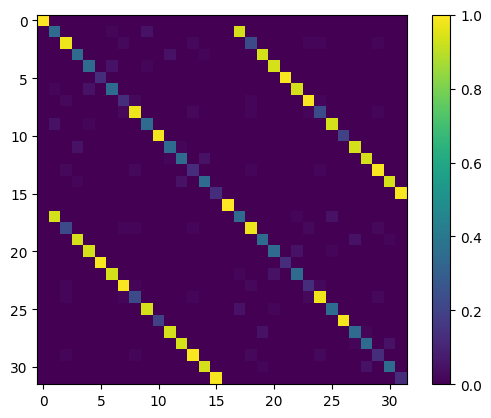

In [100]:
plt.imshow(np.abs(Circ.get_unitary()), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [115]:
#Dict={'circuit': Circ}

#with open('./gen_data/2spinTapSynt.pk', 'wb') as handle:
#    pickle.dump(Dict, handle)


In [117]:
###Transpilation to a CZ gate set...

gate_set={CZGate(), RZGate(), SXGate()}

gate_set =  {VariableUnitaryGate(2),VariableUnitaryGate(1)}


model = MachineModel(Circ.num_qudits, gate_set=gate_set)
transCirc1 = compile(Circ,model=model,max_synthesis_size=5)
#transCirc1 = compile(Circ,model=model,max_synthesis_size=4)



14:42:48.045 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.


INFO - Extracting measurements from circuit.


14:42:48.046 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


16:19:57.568 - CRITICAL | bqskit.compiler.compiler: Compiler interrupted.


CRITICAL - Compiler interrupted.


KeyboardInterrupt: 

# Post-processing generalized-gated circuit

In [123]:
###This circuit was compiled in cluster but it is feasible to do the calculations in a laptop, the issue
#is to perform the compilation to a gate set. Exploring fast approaches for the compilation


with open('../Tap_synthesis/Qfast/outputs/2spinTapSynt_rel.pk','rb') as file:
    data = pickle.load(file)


In [126]:
twospincirc = data['circuit']

In [127]:
twospincirc.depth

51

In [132]:
out_circ = compile(twospincirc, optimization_level=2)

09:51:43.683 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.


INFO - Extracting measurements from circuit.


09:51:43.684 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


09:54:02.469 - INFO     | bqskit.passes.util.log: Mapping circuit.


INFO - Mapping circuit.


09:54:02.469 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3, 4]


INFO - Placed qudits on [0, 1, 2, 3, 4]


09:54:02.525 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


INFO - Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


09:54:02.660 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3, 4]


INFO - Finished routing with layout: [0, 1, 2, 3, 4]


09:54:02.660 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


09:54:21.804 - INFO     | bqskit.passes.util.log: Attempting to delete gates.


INFO - Attempting to delete gates.


09:54:52.546 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.


INFO - Upper bound on error is 0.0.


09:54:52.601 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.


INFO - Restoring measurements to circuit.


In [131]:
out_circ.depth

485

In [133]:
out_circ.depth

456

In [142]:
from bqskit.ir.gates import CZGate, RZGate, SXGate
gate_set = {CZGate(), RZGate(), SXGate()} 

# Build a MachineModel with this gate set
# and the same number of qubits as the circuit
from bqskit import MachineModel
model = MachineModel(twospincirc.num_qudits, gate_set=gate_set)

# Compile again and print new gate counts
out_circuit = compile(twospincirc,model=model)

10:39:02.811 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.


INFO - Extracting measurements from circuit.


10:39:02.811 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


10:39:51.988 - INFO     | bqskit.passes.util.log: Mapping circuit.


INFO - Mapping circuit.


10:39:51.988 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3, 4]


INFO - Placed qudits on [0, 1, 2, 3, 4]


10:39:52.030 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


INFO - Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


10:39:52.104 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3, 4]


INFO - Finished routing with layout: [0, 1, 2, 3, 4]


10:39:52.104 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


10:39:57.476 - INFO     | bqskit.passes.util.log: Retargeting single-qudit gates.


INFO - Retargeting single-qudit gates.


10:39:58.812 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.


INFO - Upper bound on error is 0.0.


10:39:58.995 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.


INFO - Restoring measurements to circuit.


In [145]:
out_circ.depth

456

In [150]:
test_comp = compile(twospincirc,model=m odel,optimization_level=2)

10:45:46.673 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.


INFO - Extracting measurements from circuit.


10:45:46.674 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


10:47:26.535 - INFO     | bqskit.passes.util.log: Mapping circuit.


INFO - Mapping circuit.


10:47:26.535 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3, 4]


INFO - Placed qudits on [0, 1, 2, 3, 4]


10:47:26.575 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


INFO - Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


10:47:26.649 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3, 4]


INFO - Finished routing with layout: [0, 1, 2, 3, 4]


10:47:26.649 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


10:47:41.112 - INFO     | bqskit.passes.util.log: Retargeting single-qudit gates.


INFO - Retargeting single-qudit gates.


10:47:42.497 - INFO     | bqskit.passes.util.log: Attempting to delete gates.


INFO - Attempting to delete gates.


10:50:13.673 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.


INFO - Upper bound on error is 0.0.


10:50:13.834 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.


INFO - Restoring measurements to circuit.


In [149]:
test_comp.depth

1319

In [151]:
test_comp.depth

1076

In [157]:
import qiskit
from bqskit.ext import qiskit_to_bqskit

In [158]:
#####Comparison with a straightforward bqskit compilation scheme...
QisCircQs = qiskit.synthesis.qs_decomposition(EmbUn)
bqskit_circuit = qiskit_to_bqskit(QisCircQs)
#from bqskit.ext import qiskit_to_bqskit


In [160]:
CZgateQis = compile(bqskit_circuit,model=model,optimization_level=2)

10:54:19.998 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.


INFO - Extracting measurements from circuit.


10:54:20.003 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


10:54:38.495 - INFO     | bqskit.passes.util.log: Mapping circuit.


INFO - Mapping circuit.


10:54:38.495 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3, 4]


INFO - Placed qudits on [0, 1, 2, 3, 4]


10:54:38.583 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


INFO - Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]


10:54:38.769 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3, 4]


INFO - Finished routing with layout: [0, 1, 2, 3, 4]


10:54:38.769 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


INFO - Retargeting multi-qudit gates.


10:54:59.979 - INFO     | bqskit.passes.util.log: Retargeting single-qudit gates.


INFO - Retargeting single-qudit gates.


10:55:02.850 - INFO     | bqskit.passes.util.log: Attempting to delete gates.


INFO - Attempting to delete gates.


11:00:30.705 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.


INFO - Upper bound on error is 0.0.


11:00:31.032 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.


INFO - Restoring measurements to circuit.


In [161]:
CZgateQis.depth

2169

# Targeting the compilation of the 3 spin system

In [ ]:
'../data/alanineNMRdata_withrelaxation.mat'

In [ ]:
loadMat = spio.loadmat('../data/alanineNMRdata_withrelaxation.mat',squeeze_me=True)

Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()
t_grid = loadMat['p']['time_grid1'].item()

TimeGen = (-1j*Ham+R)*t_grid[t_idx]
ExpGen = expm(TimeGen)

####Embedding in unitary...

EmbUn7 = EmbedInU(ExpGen)

#nqubs = 4
#SubU = np.copy(EmbUn[0:2**nqubs,0:2**nqubs])

#SubEmbU = EmbedInU(SubU)


#in_circuit = Circuit.from_unitary(SubEmbU)
#in_circuit = Circuit.from_unitary(EmbUn7)


In [27]:
###Saving circuit...
Dict= {}

Dict['circ']=out_circuit

with open('./outputs/2spin_relaxacc.pk', 'wb') as handle:
    pickle.dump(Dict, handle)



In [32]:
####Aiming to convert the circuit in a unitary:
from bqskit.ir.gates import CZGate, RZGate, SXGate
from bqskit import MachineModel
from bqskit import compile

gate_set = {CZGate(), RZGate(), SXGate()} 
model = MachineModel(out_circuit.num_qudits, gate_set=gate_set)

# Compile again and print new gate counts
gateset_circuit = compile(out_circuit, model=model)



13:42:17.518 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.
13:42:17.518 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
13:42:57.636 - INFO     | bqskit.passes.util.log: Mapping circuit.
13:42:57.638 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3, 4]
13:42:57.646 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]
13:42:57.663 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3, 4]
13:42:57.663 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
13:43:00.580 - INFO     | bqskit.passes.util.log: Retargeting single-qudit gates.
13:43:00.810 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.
13:43:00.837 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.


In [33]:
gateset_circuit.depth

227

In [50]:
unit,grad= gateset_circuit.get_unitary_and_grad()
unit=np.array(unit)
refunit,grad = in_circuit.get_unitary_and_grad()
refunit = np.array(refunit)

In [45]:
refunit,grad = in_circuit.get_unitary_and_grad()

In [51]:
np.linalg.norm(unit-refunit)

10.430902049930136

In [54]:
prod = unit.conjugate().T@refunit

In [55]:
prod[0,0]

(-0.7213681611552899+0.6790325278700529j)

In [59]:
prod[4,4]

(-0.6486151979971866+0.7591583683639309j)

In [60]:
Compiler?

Init signature:
Compiler(
    ip: 'str | None' = None,
    port: 'int' = 7472,
    num_workers: 'int' = -1,
    runtime_log_level: 'int' = 30,
    worker_port: 'int' = 7474,
) -> 'None'
Docstring:     
A compiler is responsible for accepting and managing compilation tasks.

The compiler class either spins up a parallel runtime or connects to
a distributed one, which compilation tasks can then access to
parallelize their operations. The compiler is implemented as a
context manager and it is recommended to use it as one. If the
compiler is not used in a context manager, it is the responsibility
of the user to call `close()`.

Examples:
    1. Use in a context manager:
    >>> with Compiler() as compiler:
    ...     circuit = compiler.compile(circuit, workflow)

    2. Use compiler without context manager:
    >>> compiler = Compiler()
    >>> circuit = compiler.compile(circuit, workflow)
    >>> compiler.close()

    3. Connect to an already running distributed runtime:
    >>> with Com

In [23]:
2108/60

35.13333333333333

In [24]:
out_circuit.gate_counts

{VariableUnitaryGate(2, (2, 2)): 3, VariableUnitaryGate(1, (2,)): 3}

In [ ]:
22.320951299043372 #custom layer

In [ ]:
37.46070059 #simple layer

In [ ]:
#simple layer 4 qubits...
156.2895126669

In [ ]:
#custom layer 4 qubits...
315.6711452880408

In [13]:
out_circuit.coupling_graph

{(0, 1), (0, 2)}

In [19]:
out_circuit

Circuit(3)
	[VariableUnitaryGate(1, (2,))([0.05736180381701095, 0.8997383519393836, 0.26024763054952516, -0.06211777207163331, 0.07343988571161895, 0.4263649900014365, 0.9610345349897061, -0.06946348496392578])@(0,), VariableUnitaryGate(1, (2,))([0.46082287458272986, 0.17370319694264036, 0.09147855575881755, 0.4750828746006062, -0.11814248788840628, 0.8622713205185207, 0.8748235848747611, -0.024731183642867013])@(1,), VariableUnitaryGate(1, (2,))([0.7233866034842831, 0.19258943103184728, -0.4674503464950687, 0.5832786670493721, -0.13302009044345997, 0.6495589184151933, 0.49041579399477586, 0.4480720021684256])@(2,)]
	[VariableUnitaryGate(2, (2, 2))([0.37732917344218353, 0.019433861256634863, 0.5290166772158355, -0.09510515063173045, -0.46830349265353266, 0.3716900266523315, 0.20113894322080642, 0.12492040171935022, 0.5320672758593762, 0.328987614765045, -0.30992548331900943, 0.1736617207920815, -0.3666500535239928, -0.4258898197483759, 0.03916824336546594, 0.634854737874359, 0.42281544

In [18]:
compile(out_circuit,optimization_level=1)

11:37:29.844 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.
11:37:29.844 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.


thread '<unnamed>' panicked at src/ir/gates/optimize.rs:8:9:
not implemented
stack backtrace:
thread '<unnamed>' panicked at src/ir/gates/optimize.rs:8:9:
not implemented
thread '<unnamed>' panicked at src/ir/gates/optimize.rs:8:9:
not implemented
stack backtrace:
stack backtrace:
thread '<unnamed>' panicked at src/ir/gates/optimize.rs:8:9:
not implemented
stack backtrace:
   0: _rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::panicking::panic
   3: <bqskitrs::ir::operation::Operation as bqskitrs::ir::gates::optimize::Optimize>::optimize
   4: <bqskitrs::ir::inst::qfactor::QFactorInstantiator as bqskitrs::ir::inst::Instantiate>::instantiate
   5: bqskitrs::python::instantiators::qfactor::_::<impl bqskitrs::python::instantiators::qfactor::PyQFactorInstantiator>::__pymethod_instantiate__
   0: _rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::panicking::panic
   0: _rust_begin_unwind 
  3:  < bqskitrs ::1ir: ::coreoperation::Operation as bqskitrs::::panicking

RuntimeError: Server connection unexpectedly closed.

In [17]:
out_circuit.depth

7

In [9]:
from bqskit.ir.gates import CZGate, RZGate, SXGate
from bqskit import compile
gate_set = {CZGate(), RZGate(), SXGate()} 

# Build a MachineModel with this gate set
# and the same number of qubits as the circuit
from bqskit import MachineModel
model = MachineModel(out_circuit.num_qudits, gate_set=gate_set)

# Compile again and print new gate counts
out_circuit = compile(out_circuit, model=model)

NameError: name 'out_circuit' is not defined

# Starting from an initial guess obtained from other synthesizer

In [19]:
from bqskit.ir.gates import CZGate, RZGate, SXGate
from bqskit import compile
gate_set = {CZGate(), RZGate(), SXGate()} 




In [11]:
from bqskit.ext import qiskit_to_bqskit

from bqskit.passes import QuickPartitioner

import qiskit

In [12]:
t_idx = 256

In [35]:
#loadMat = spio.loadmat('../data/alanineNMRdata_withrelaxation.mat',squeeze_me=True)
loadMat = spio.loadmat('../data/DFG.mat')

Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()
t_grid = loadMat['p']['time_grid1'].item()

TimeGen = (-1j*Ham+R)*t_grid[0][t_idx]
ExpGen = expm(TimeGen)

####Embedding in unitary...

EmbUn = EmbedInU(ExpGen)
in_circuit = Circuit.from_unitary(EmbUn)
#nqubs = 2
#SubU = np.copy(EmbUn[0:2**nqubs,0:2**nqubs])

#SubEmbU = EmbedInU(SubU)


In [34]:
np.linalg.norm(EmbUn@EmbUn.conj().T-np.eye(32))

5.6336749385813135e-11

In [36]:
Circuit

Circuit(5)
	[ConstantUnitaryGate@(0, 1, 2, 3, 4), ConstantUnitaryGate@(0, 1, 2, 3, 4), ConstantUnitaryGate@(0, 1, 2, 3, 4), ConstantUnitaryGate@(0, 1, 2, 3, 4), ConstantUnitaryGate@(0, 1, 2, 3, 4)]

0.0011560693641618496

In [29]:
t_grid[0]

array([0.        , 0.00011561, 0.00023121, 0.00034682, 0.00046243,
       0.00057803, 0.00069364, 0.00080925, 0.00092486, 0.00104046,
       0.00115607, 0.00127168, 0.00138728, 0.00150289, 0.0016185 ,
       0.0017341 , 0.00184971, 0.00196532, 0.00208092, 0.00219653,
       0.00231214, 0.00242775, 0.00254335, 0.00265896, 0.00277457,
       0.00289017, 0.00300578, 0.00312139, 0.00323699, 0.0033526 ,
       0.00346821, 0.00358382, 0.00369942, 0.00381503, 0.00393064,
       0.00404624, 0.00416185, 0.00427746, 0.00439306, 0.00450867,
       0.00462428, 0.00473988, 0.00485549, 0.0049711 , 0.00508671,
       0.00520231, 0.00531792, 0.00543353, 0.00554913, 0.00566474,
       0.00578035, 0.00589595, 0.00601156, 0.00612717, 0.00624277,
       0.00635838, 0.00647399, 0.0065896 , 0.0067052 , 0.00682081,
       0.00693642, 0.00705202, 0.00716763, 0.00728324, 0.00739884,
       0.00751445, 0.00763006, 0.00774566, 0.00786127, 0.00797688,
       0.00809249, 0.00820809, 0.0083237 , 0.00843931, 0.00855

In [14]:
nworkers=6

In [15]:

inst_opts = {'method':'qfactor'}



passes = [

    # Split the circuit into partitions
   #QSearchSynthesisPass(instantiate_options=instantiate_options),
   QSearchSynthesisPass(layer_generator=SimpleLayerGenerator(two_qudit_gate=VariableUnitaryGate(2),single_qudit_gate_1=VariableUnitaryGate(1)),
             success_threshold=1e-3,max_layer=5000,instantiate_options=inst_opts)
   
   #QSearchSynthesisPass(layer_generator=LayerGenDef.AltLayer(),instantiate_options=instantiate_options)

]

# Create the compilation task

with Compiler(
    num_workers=nworkers,
    runtime_log_level=logging.INFO,
) as compiler:

    print('Starting flow using Sample QFactor JAX')
    start = timer()
    out_circuit = compiler.compile(in_circuit, passes)
    end = timer()
    run_time = end - start





Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Node has spawned 6 workers.
Connected to client.
AttachedServer running...
New CompilationTask: d74bea40-3741-44b3-a2c7-6dde60055a6c.


Starting flow using Sample QFactor JAX
16:43:27.814 - CRITICAL | bqskit.compiler.compiler: Compiler interrupted.


Server interrupted.
Shutting down node.
Shutting down node.
Shutting down node.


KeyboardInterrupt: 

In [108]:
inst_opts = {'method':'minimization'}
partition_size = 6

#qfact_workflow = Workflow([
#    QuickPartitioner(3),  
#    QSearchSynthesisPass(success_threshold=1e-3, instantiate_options=inst_opts), 
    
#    ])

passes = [
        # Convert U3's to VU
        #ToVariablePass(convert_all_single_qudit_gates=True),

        # Split the circuit into partitions
        QuickPartitioner(partition_size),

        # For each partition perform scanning gate removal using QFactor jax
        ForEachBlockPass([
            ScanningGateRemovalPass(
                instantiate_options=inst_opts,
            ),
        ]),

        # Combine the partitions back into a circuit
        UnfoldPass(),

        # Convert back the VariablueUnitaires into U3s
        #ToU3Pass(),
    ]


In [16]:
QisCircQs = qiskit.synthesis.qs_decomposition(EmbUn)
bqskit_circuit = qiskit_to_bqskit(QisCircQs)

In [17]:
#bqskit_circuit = qiskit_to_bqskit(QisCircQs)

In [18]:
bqskit_circuit.gate_counts

{U3Gate: 518,
 CircuitGate(Circuit(2)[U3Gate@(0,) ... U3Gate@(1,)]): 63,
 CNOTGate: 315,
 CircuitGate(Circuit(2)[U3Gate@(0,) ... U3Gate@(1,)]): 1}

In [22]:
from bqskit import MachineModel
model = MachineModel(bqskit_circuit.num_qudits, gate_set=gate_set)

# Compile again and print new gate counts
out_circuit = compile(bqskit_circuit, model=model)

16:50:50.531 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.
16:50:50.537 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
16:51:10.142 - INFO     | bqskit.passes.util.log: Mapping circuit.
16:51:10.142 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3, 4]
16:51:10.220 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3, 4], new placement: [0, 1, 2, 3, 4]
16:51:10.397 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3, 4]
16:51:10.397 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
16:51:20.192 - INFO     | bqskit.passes.util.log: Retargeting single-qudit gates.
16:51:23.083 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.
16:51:23.420 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.


In [25]:
out_circuit

Circuit(5)
	[RZGate([-2.076634973015725])@(0,), RZGate([0.19232388043645976])@(1,), RZGate([-1.316104582655224])@(2,), RZGate([0.11730505925184298])@(3,), RZGate([-0.09817477040183675])@(4,)]
	[SqrtXGate@(0,), SqrtXGate@(1,), SqrtXGate@(2,), SqrtXGate@(3,), SqrtXGate@(4,)]
	[RZGate([-0.7295527393513623])@(0,), RZGate([-1.032607389012476])@(1,), RZGate([-1.44705055829181])@(2,), RZGate([-1.5707963267948877])@(3,), RZGate([-1.57079632663795])@(4,)]
	[SqrtXGate@(0,), SqrtXGate@(1,), SqrtXGate@(2,), SqrtXGate@(3,), SqrtXGate@(4,)]
	[RZGate([-2.8789894859571836])@(0,), RZGate([-0.2571831280290411])@(1,), RZGate([-2.2889652401942646])@(2,), RZGate([-1.413485126983094])@(3,), RZGate([-0.5998855965277947])@(4,)]
	[None, CZGate@(1, 2), CZGate@(1, 2), None, None]
	[None, RZGate([-1.646939605690726])@(1,), RZGate([-2.626143268765907])@(2,), None, None]
	[None, SqrtXGate@(1,), SqrtXGate@(2,), None, None]
	[None, RZGate([-2.3596629898286645])@(1,), RZGate([-2.799697809480608])@(2,), None, None]
	[N

In [ ]:
with Compiler() as compile:
    out_circuit = compiler.compile(bqskit_circuit, )
    

In [21]:
Compiler().compile?

Signature:
compile(
    input: 'CompilationInputLike | Sequence[CompilationInput]',
    model: 'MachineModel | None' = None,
    optimization_level: 'int' = 1,
    max_synthesis_size: 'int' = 3,
    synthesis_epsilon: 'float' = 1e-08,
    error_threshold: 'float | None' = None,
    error_sim_size: 'int' = 8,
    compiler: 'Compiler | None' = None,
    seed: 'int | None' = None,
    with_mapping: 'bool' = False,
    **compiler_kwargs: 'Any',
) -> 'Circuit | tuple[Circuit, tuple[int, ...], tuple[int, ...]] | list[Circuit] | list[tuple[Circuit, tuple[int, ...], tuple[int, ...]]]'
Docstring:
Compile a circuit, unitary, or state with a standard workflow.

Args:
    input (CompilationInputLike | Sequence[CompilationInput]): The input
        or inputs to compile. If a single input is given, a single
        circuit will be returned. If an iterable of inputs is given,
        a list of circuits will be returned.

    model (MachineModel | None): A model of the target machine.
        Defaults

In [113]:
bqskit_circuit.depth

815

In [ ]:
bq

In [ ]:
#####

In [ ]:
with Compiler(
        num_workers=nworkers,
        runtime_log_level=logging.INFO,
    ) as compiler:

        print('Starting flow')
        start = timer()
        out_circuit = compiler.compile(bqskit_circuit, passes)
        end = timer()
        run_time = end - start

Started outgoing thread.
Registered worker 0.
Registered worker 1.
Registered worker 2.
Registered worker 3.
Registered worker 4.
Registered worker 5.
Node has spawned 6 workers.


Starting flow


Connected to client.
AttachedServer running...
New CompilationTask: 220ee26b-3c17-4f55-9ee6-40cb26e8a682.


16:06:01.945 - CRITICAL | bqskit.compiler.compiler: Compiler interrupted.


Server interrupted.
Shutting down node.


In [107]:
out_circuit.gate_counts

{U3Gate: 776, CNOTGate: 440}

In [102]:
out_circuit.depth

904

In [48]:
bqskit_circuit.depth

27